# RL and Advanced DL: Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения


1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


In [2]:
import gym
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict, deque

### Tic Tac Toe environment из семинара

In [3]:
EMPTY = 0
CROSSES_TURN = 1
NOUGHTS_TURN = -1

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        if clone is not None:
            self.n_rows = clone.n_rows
            self.n_cols = clone.n_cols
            self.n_win = clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = "".join(
                [f"{x + 1}"
                 for x in self.board.reshape(self.n_rows * self.n_cols)]
            )
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p
                                        for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p
                                        for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print("----" * (self.n_cols) + "-")
            out = "| "
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = "x"
                if self.board[i, j] == -1:
                    token = "o"
                if self.board[i, j] == 0:
                    token = " "
                out += token + " | "
            print(out)
        print("----" * (self.n_cols) + "-")

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn, self.board)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    @staticmethod
    def next_turn(turn):
        return -turn

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = self.next_turn(self.curTurn)
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

### Стратегии: Random и EpsGreedy

In [5]:
def get_pi(pi_crosses, pi_noughts, turn):
    return pi_crosses if turn == CROSSES_TURN else pi_noughts


class BasePolicy:
    def __init__(self, turn):
        self.turn = turn
    
    def check_win(self, reward):
        if reward == CROSSES_TURN:
            return 1 if self.turn == CROSSES_TURN else -1
        if reward == NOUGHTS_TURN:
            return 1 if self.turn == NOUGHTS_TURN else -1
        return 0 # draw
    
    def select_action_idx(self, state, eps):
        return None # should be implemented
    
    def select_action(self, state, eps):
        is_action_int = False
        _, allowed_actions, _, _ = state
        action_idx = self.select_action_idx(state, eps)
        return allowed_actions[action_idx], is_action_int

    
class RandomPolicy(BasePolicy):
    
    def select_action_idx(self, state, eps):
        _, allowed_actions, _, _ = state
        action_idx = np.random.randint(len(allowed_actions))
        return action_idx

    
class EpsGreedyPolicy(BasePolicy):
    def __init__(self, turn):
        super().__init__(turn)
        self.Q = {}
    
    def select_action_idx(self, state, eps):
        board_hash, allowed_actions, _, _ = state
        
        if random.random() >= eps and board_hash in self.Q:
            return np.argmax(self.Q[board_hash])

        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(allowed_actions))

        return np.random.randint(len(allowed_actions))

### Валидация обученной стратегии: проверяем winrate pi_eval относительно pi_other, во время обучения будем валидироваться относительно случайно стратегии

In [6]:
def run_eval_episode(env, policies, eps, ):
    
    env.reset()
    state = env.getState()
    _, _, turn, _ = state

    done = False
    while not done:
        action, is_action_int = policies[turn].select_action(state, eps)
        action = action if not is_action_int else env.action_from_int(action)
        state, reward, done, _ = env.step(action)
        _, _, turn, _ = state

    return reward

In [7]:
def eval_policy(env, pi_eval, pi_other, episodes, verbose=False):
    """
    eval pi_eval vs pi_other,
    returns winrate, looserate, drawrate
    """
    policies = dict()
    policies[CROSSES_TURN] = pi_eval  if pi_eval.turn == CROSSES_TURN  else pi_other
    policies[NOUGHTS_TURN] = pi_other if pi_other.turn == NOUGHTS_TURN else pi_eval
    assert policies[CROSSES_TURN].turn == CROSSES_TURN
    assert policies[NOUGHTS_TURN].turn == NOUGHTS_TURN
    
    wins = 0
    looses = 0
    draws = 0

    for _ in tqdm(range(episodes), disable = not verbose):
        reward = run_eval_episode(env, policies, eps=0)
        is_win = pi_eval.check_win(reward)
        wins += int(is_win == 1)
        looses += int(is_win == -1)
        draws += int(is_win == 0)

    return wins / episodes, looses / episodes, draws / episodes

In [8]:
def plot_history(history, player, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title(f'Average rates during training: {player}', fontsize=fontsize)
    plt.xlabel('Step', fontsize=fontsize)
    plt.ylabel('Average rate', fontsize=fontsize)
    history = history[player]
    x = [s for s, _, _, _ in history]
    wr = [s for _, s, _, _ in history]
    lr = [s for _, _, s, _ in history]
    dr = [s for _, _, _, s in history]
    plt.plot(x, wr, label="winrate")
    plt.plot(x, lr, label="looserate")
    plt.plot(x, dr, label="drawrate")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Sanity checks для random policy

In [ ]:
ENV = TicTacToe(n_rows=3, n_cols=3, n_win=3)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), RandomPolicy(turn=NOUGHTS_TURN), episodes=1000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN),  RandomPolicy(turn=CROSSES_TURN), episodes=1000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

ENV = TicTacToe(n_rows=4, n_cols=4, n_win=4)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), RandomPolicy(turn=NOUGHTS_TURN), episodes=1000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN),  RandomPolicy(turn=CROSSES_TURN), episodes=1000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

ENV = TicTacToe(n_rows=5, n_cols=5, n_win=5)
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=CROSSES_TURN), RandomPolicy(turn=NOUGHTS_TURN), episodes=1000)
print(f'CrossRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}')
wr, lr, dr = eval_policy(ENV, RandomPolicy(turn=NOUGHTS_TURN),  RandomPolicy(turn=CROSSES_TURN), episodes=1000)
print(f'NoughtsRandomPolicy on {ENV.n_cols}x{ENV.n_rows}: winrate={wr}, looserate={lr}, drawrate={dr}\n')

CrossRandomPolicy on 3x3: winrate=0.583, looserate=0.287, drawrate=0.13
NoughtsRandomPolicy on 3x3: winrate=0.302, looserate=0.576, drawrate=0.122

CrossRandomPolicy on 4x4: winrate=0.325, looserate=0.278, drawrate=0.397
NoughtsRandomPolicy on 4x4: winrate=0.248, looserate=0.331, drawrate=0.421

CrossRandomPolicy on 5x5: winrate=0.268, looserate=0.143, drawrate=0.589
NoughtsRandomPolicy on 5x5: winrate=0.17, looserate=0.257, drawrate=0.573



### Обучаем EpsGreedy стратегию с помощью Q-learning

In [9]:
def q_learning_train_epoch(env, policies, args):

    env.reset()
    state = env.getState()
    board_hash, allowed_actions, turn, _ = state
    prev_board_hash, prev_action_idx = None, None

    done = False
    while not done:
        
        # update curr turn policy
        pi = policies[turn]
        action_idx = pi.select_action_idx(state, args['eps'])
        action = allowed_actions[action_idx]
        state, reward, done, _ = env.step(action)
        if reward == turn:
            pi.Q[board_hash][action_idx] = abs(reward)
        policies[turn] = pi

        # update opposite policy
        next_board_hash, next_allowed_actions, next_turn, _ = state
        pi = policies[next_turn]
        if prev_board_hash is not None:
            gamma_term = args['gamma'] * np.max(pi.Q[next_board_hash]) if next_board_hash in pi.Q else 0
            pi.Q[prev_board_hash][prev_action_idx] += args['alpha'] * (
                -reward + gamma_term - pi.Q[prev_board_hash][prev_action_idx]
            )
        policies[next_turn] = pi

        prev_board_hash, prev_action_idx = board_hash, action_idx
        board_hash, allowed_actions, turn, _ = state

    return policies

In [10]:
def run_learning(env, pi_crosses, pi_noughts, run_train_epoch, args,
                 episodes = 10000, eps_init = 0.9, eps_final = 0.01):
    
    eval_every = int(episodes * 0.05)
    eval_episodes = int(episodes * 0.05)
    eps_decay = int(episodes * 0.8)
    
    policies = dict()
    policies[CROSSES_TURN] = pi_crosses
    policies[NOUGHTS_TURN] = pi_noughts
    assert pi_crosses.turn == CROSSES_TURN
    assert pi_noughts.turn == NOUGHTS_TURN
    
    hist = defaultdict(list)
    for epoch in tqdm(range(episodes)):
        
        args['eps'] = eps_init + (eps_final - eps_init) * epoch / eps_decay
        policies = run_train_epoch(env, policies, args)

        if (epoch + 1) % eval_every == 0:
            step = epoch + 1
            wr, lr, dr = eval_policy(env, policies[CROSSES_TURN], RandomPolicy(NOUGHTS_TURN), eval_episodes)
            hist['crosses'].append((step, wr, lr, dr))
            wr, lr, dr = eval_policy(env, policies[NOUGHTS_TURN], RandomPolicy(CROSSES_TURN), eval_episodes)
            hist['noughts'].append((step, wr, lr, dr))

    return hist

100%|██████████| 1000/1000 [00:02<00:00, 462.92it/s]


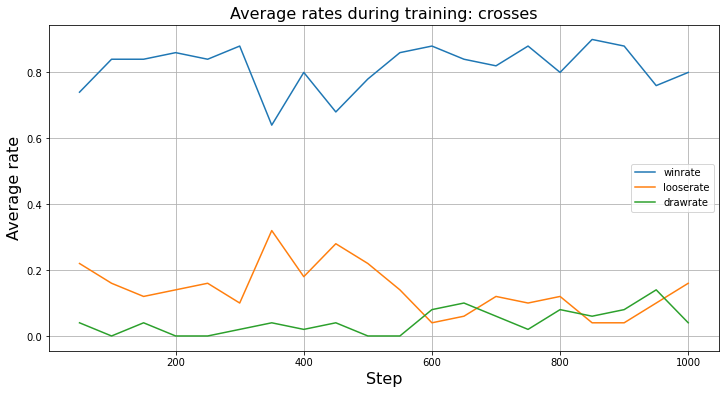

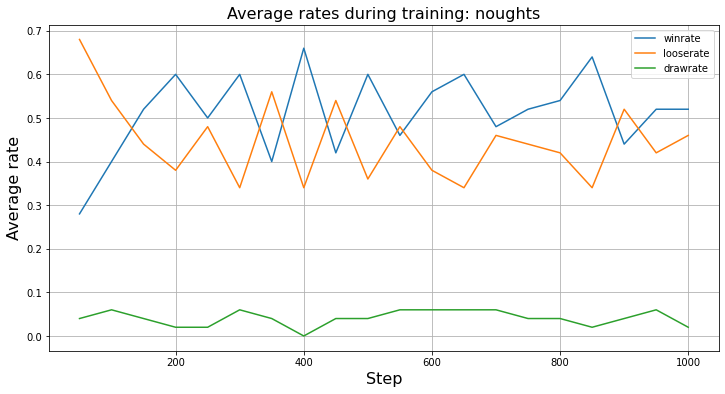

In [11]:
hist = run_learning(
    TicTacToe(n_rows=3, n_cols=3, n_win=3),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    run_train_epoch=q_learning_train_epoch,
    args={'alpha': 0.01, 'gamma': 0.08},
    episodes=1000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

100%|███████████████████████████████████| 20000/20000 [00:18<00:00, 1089.87it/s]


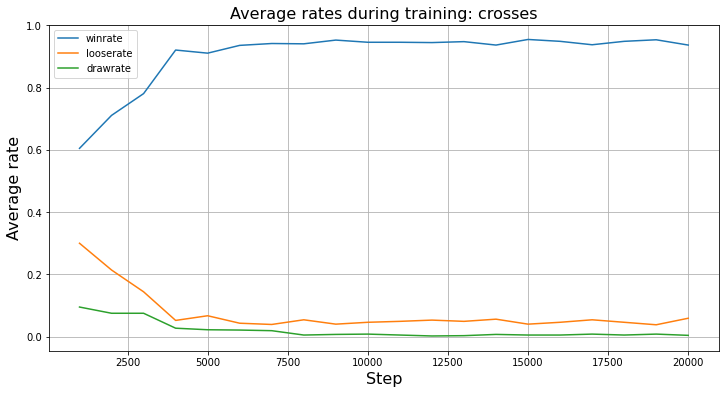

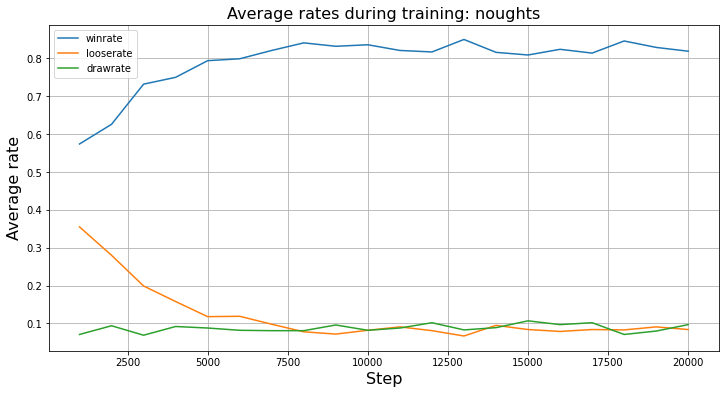

In [ ]:
hist = run_learning(
    TicTacToe(n_rows=3, n_cols=3, n_win=3),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    run_train_epoch=q_learning_train_epoch,
    args={'alpha': 0.01, 'gamma': 0.08},
    episodes=20000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

100%|████████████████████████████████████| 40000/40000 [01:34<00:00, 422.58it/s]


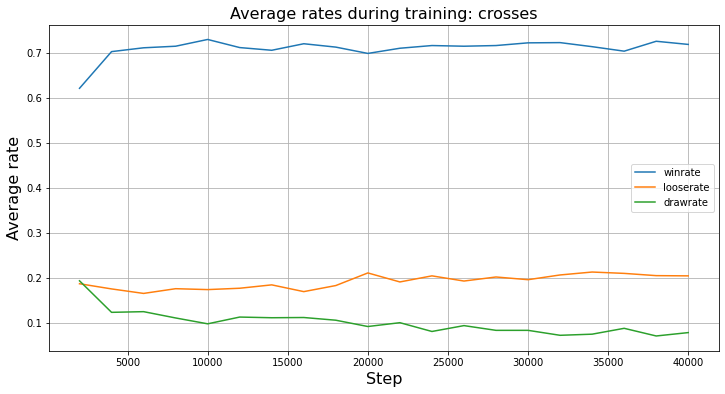

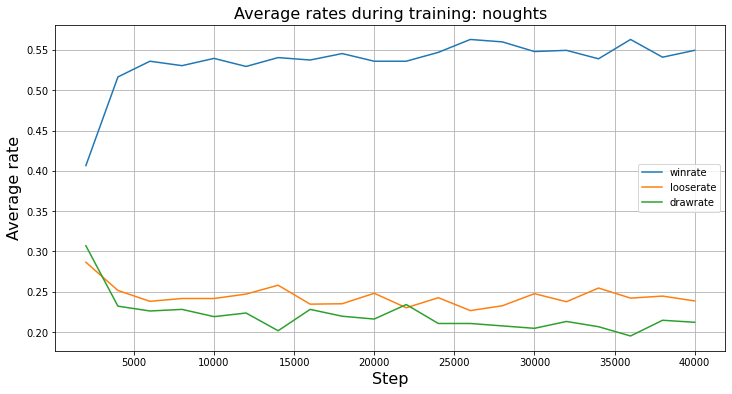

In [ ]:
hist = run_learning(
    TicTacToe(n_rows=4, n_cols=4, n_win=4),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    run_train_epoch=q_learning_train_epoch,
    args={'alpha': 0.01, 'gamma': 0.08},
    episodes=40000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

100%|████████████████████████████████████| 80000/80000 [07:10<00:00, 185.64it/s]


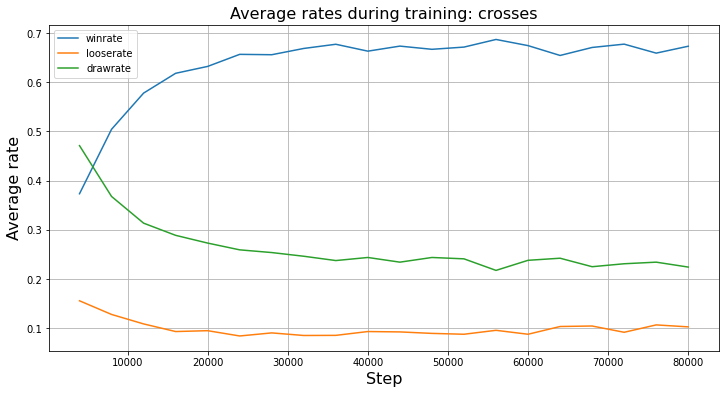

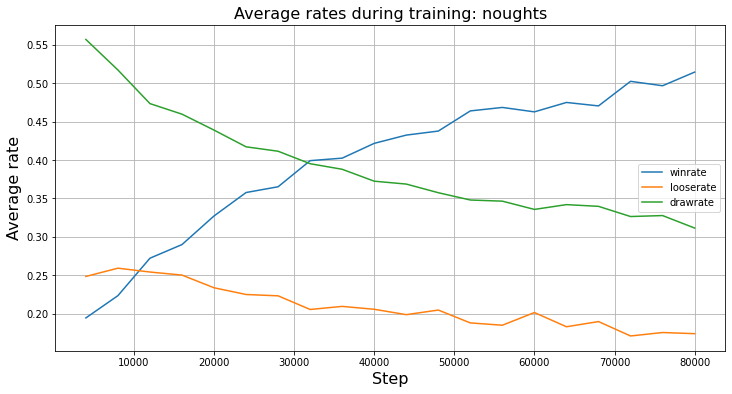

In [ ]:
hist = run_learning(
    TicTacToe(n_rows=5, n_cols=5, n_win=5),
    pi_crosses=EpsGreedyPolicy(turn=CROSSES_TURN),
    pi_noughts=EpsGreedyPolicy(turn=NOUGHTS_TURN),
    run_train_epoch=q_learning_train_epoch,
    args={'alpha': 0.01, 'gamma': 0.08},
    episodes=80000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Note: скорее всего, experience replay потребуется сразу же.
2. Реализуйте Double DQN и/или Dueling DQN.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
class DQN(nn.Module):
    def __init__(self, env, hidden_dim: int = 256):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(env.n_rows, 2 * hidden_dim, env.n_cols).to(device)
        self.l1 = nn.Linear(2 * hidden_dim, hidden_dim).to(device)
        self.l2 = nn.Linear(hidden_dim, env.n_rows * env.n_cols).to(device)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [19]:
class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def store(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size: int = 64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [20]:
class DQNAgent(BasePolicy):

    def reset(self):
        self.action = None 
        self.reward = None
        self.board = None
        self.new_board = None

    def __init__(self, turn, model: nn.Module, lr: float = 1e-5, memory_capacity: int = 30000):
        super().__init__(turn)
        self.reset()
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        self.memory = ReplayMemory(capacity=memory_capacity)


    def select_action(self, state, eps: float = 0.1):
        is_action_int = True
        _, _, _, board = state
        if random.random() < eps:
            action_int = random.choice(np.nonzero(board.flatten() == 0)[0])
            return action_int, is_action_int

        self.model.eval()
        board = np.stack(
            [
                (board == CROSSES_TURN).astype(float),
                (board == NOUGHTS_TURN).astype(float),
                (board == EMPTY).astype(float)
            ]
        )
        board = torch.FloatTensor(board).unsqueeze(0).to(device)
        action_int = self.model(board).detach().max(1).indices.item()
        return action_int, is_action_int
        
    def update(self, new_state, action, reward, done):
        _, _, _, new_board = new_state
        new_board = np.stack(
            [
                (new_board == CROSSES_TURN).astype(float),
                (new_board == NOUGHTS_TURN).astype(float),
                (new_board == EMPTY).astype(float)
            ]
        )
        if self.board is not None:
            self.memory.store((self.board, new_board, self.action, reward, done))
        self.board = new_board
        self.action = action
    
    def train_batch(self, batch_size=256, gamma=0.9):    
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        board, next_board, actions, rewards, dones = list(zip(*transitions))
        
        states = np.array(board)
        next_states = np.array(next_board)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        batch_board = torch.FloatTensor(board).to(device)
        batch_next_board = torch.FloatTensor(next_board).to(device)
        batch_actions = torch.LongTensor(actions).reshape(-1, 1).to(device)
        batch_reward = torch.FloatTensor(rewards).reshape(-1, 1).to(device)
        batch_dones = torch.BoolTensor(rewards).reshape(-1, 1).to(device)

        self.model.train()
        Q = self.model(batch_board).gather(1, batch_actions)

        with torch.no_grad():
            Qnext = self.model(batch_next_board).max(dim=1).values.reshape(-1, 1)
            Qnext[batch_dones] = 0
            Qnext = batch_reward + gamma * Qnext

        loss = F.l1_loss(Q, Qnext)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

In [24]:
def dqn_learning_train_epoch(env, agents, args):
    env.reset()
    for key in agents:
        agents[key].model.eval()
        agents[key].reset()
        
    state = env.getState()

    done = False
    while not done:
        _, _, turn, _ = state
        current = agents[turn]
        action_int, _ = current.select_action(state, args['eps'])
        current.update(state, action_int, 0, done)
        state, reward, done, _ = env.step(env.action_from_int(action_int))

    if reward == -10:
        current.update(state, action_int, reward, done)
    else:
        agents[CROSSES_TURN].update(state, action_int, reward, done)
        agents[NOUGHTS_TURN].update(state, action_int, -reward, done)
    
    agents[CROSSES_TURN].train_batch(args['batch_size'], args['gamma'])
    agents[NOUGHTS_TURN].train_batch(args['batch_size'], args['gamma'])
    return agents

100%|██████████| 10000/10000 [09:08<00:00, 18.25it/s]


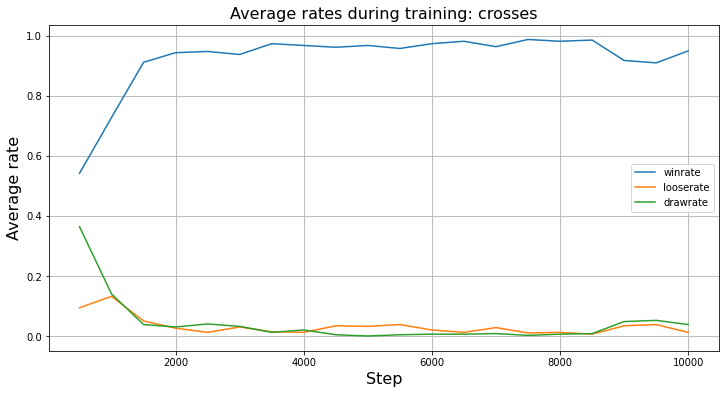

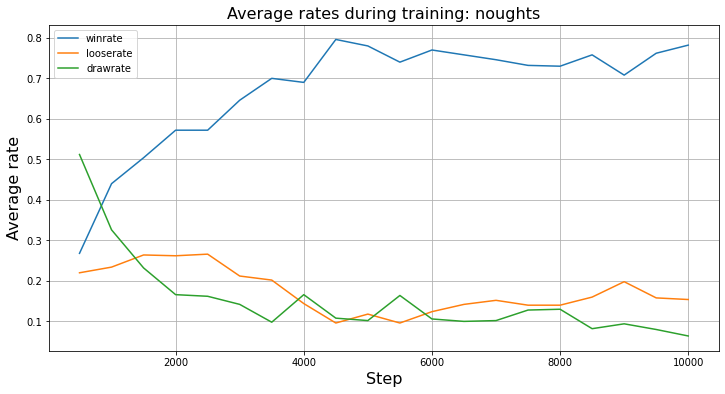

In [25]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
hist = run_learning(
    env=env,
    pi_crosses=DQNAgent(turn=CROSSES_TURN, model=DQN(env)),
    pi_noughts=DQNAgent(turn=NOUGHTS_TURN, model=DQN(env)),
    run_train_epoch=dqn_learning_train_epoch,
    args={'batch_size': 512, 'gamma': 0.9},
    episodes=10000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')

In [26]:
class DDQNAgent(DQNAgent):

    def __init__(self, turn, model: nn.Module, lr: float = 1e-5, memory_capacity: int = 30000):
        super().__init__(turn, model, lr, memory_capacity)
        self.steps = 0
        self.target_model = copy.deepcopy(self.model) 
    
    def __train_batch(self, batch_size=256, gamma=0.9):    
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        states, next_states, actions, rewards, dones = list(zip(*transitions))
        
        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        batch_state = torch.FloatTensor(states).to(device)
        batch_next_state = torch.FloatTensor(next_states).to(device)
        batch_actions = torch.LongTensor(actions).reshape(-1, 1).to(device)
        batch_reward = torch.FloatTensor(rewards).reshape(-1, 1).to(device)
        batch_dones = torch.BoolTensor(rewards).reshape(-1, 1).to(device)

        self.model.train()
        Q = self.model(batch_state).gather(1, batch_actions)

        with torch.no_grad():
            Qnext = self.target_model(batch_next_state).max(dim=1).values.reshape(-1, 1)
            Qnext[batch_dones] = 0
            Qnext = batch_reward + gamma * Qnext

        loss = F.l1_loss(Q, Qnext)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_batch(
        self, batch_size=256, gamma=0.9,
        steps_per_update=4, 
        steps_per_target_update=4*100
    ):
        if self.steps % steps_per_update == 0:
            self.__train_batch(batch_size, gamma)
        if self.steps % steps_per_target_update == 0:
            self.update_target_model()
        self.steps += 1

100%|██████████| 30000/30000 [05:46<00:00, 86.63it/s] 


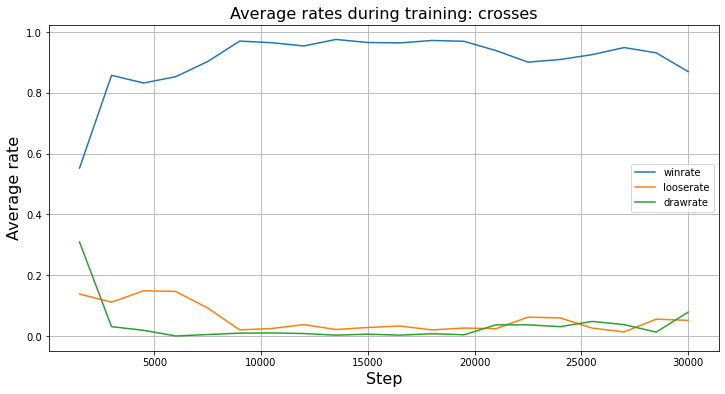

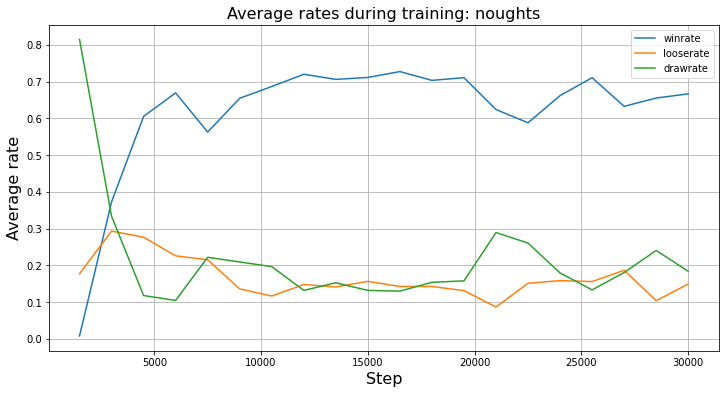

In [28]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
hist = run_learning(
    env=env,
    pi_crosses=DDQNAgent(turn=CROSSES_TURN, model=DQN(env)),
    pi_noughts=DDQNAgent(turn=NOUGHTS_TURN, model=DQN(env)),
    run_train_epoch=dqn_learning_train_epoch,
    args={'batch_size': 512, 'gamma': 0.9},
    episodes=30000
)
plot_history(hist, player='crosses')
plot_history(hist, player='noughts')